In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
# %%
import zipfile

with zipfile.ZipFile("/content/data.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data")

print("✅ Đã giải nén dữ liệu")

✅ Đã giải nén dữ liệu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# %%
import torch, os
from torchvision import transforms, datasets
from torch.utils.data import ConcatDataset, Subset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
from torchvision.models import resnet50
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Giá trị trung bình và độ lệch chuẩn của ImageNet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# Tiền xử lý và augmentation cho tập huấn luyện
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(10),
    transforms.Grayscale(num_output_channels=3), # Giữ lại nếu dữ liệu gốc xám
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std) # Hoặc tính trên dataset của bạn
])

# Tiền xử lý cho tập kiểm định và tập test (không augmentation)
transform_eval = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3), # Giữ lại nếu dữ liệu gốc xám
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std) # Hoặc tính trên dataset của bạn
])

# Load dữ liệu huấn luyện (sẽ áp dụng transform_train)
ds_train_full = datasets.ImageFolder("/content/data/train", transform=transform_train)

# Chia tầng tập huấn luyện thành huấn luyện và kiểm định
targets = np.array(ds_train_full.targets)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in sss.split(np.zeros(len(targets)), targets):
    train_ds = Subset(ds_train_full, train_idx)
    # Sử dụng transform_eval cho tập kiểm định
    val_ds   = Subset(datasets.ImageFolder("/content/data/train", transform=transform_eval), val_idx)

# Load dữ liệu test (sẽ áp dụng transform_eval)
test_ds = datasets.ImageFolder("/content/data/test", transform=transform_eval)

# Tạo DataLoader
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

class_names = ds_train_full.classes
print("📊 Train:", len(train_ds), "| Val:", len(val_ds), "| Test:", len(test_ds))

# %%

📊 Train: 22967 | Val: 5742 | Test: 7178


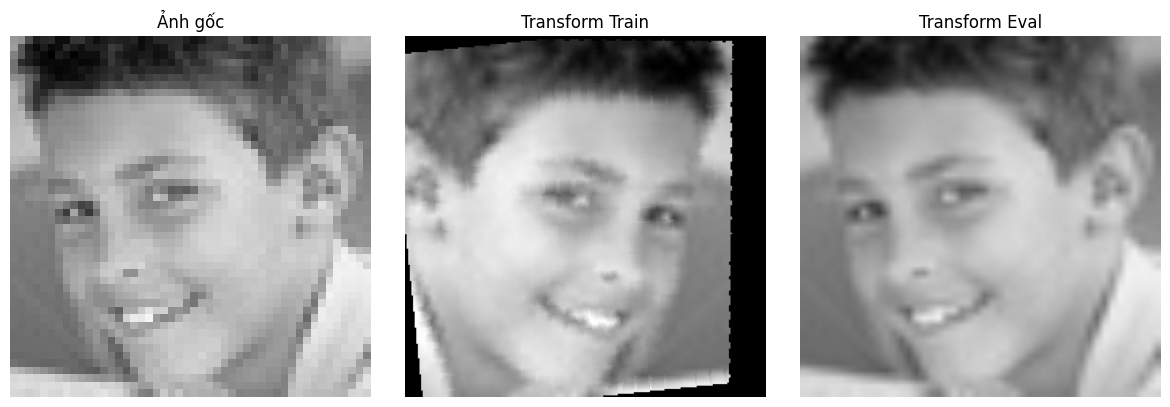

In [ ]:
# demo transform
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import torch
import os

# Đường dẫn ảnh demo
img_path = "/content/data/train/happy"
img_file = os.listdir(img_path)[0]
img = Image.open(os.path.join(img_path, img_file)).convert("RGB")

# Mean/Std chuẩn ImageNet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),                    # ➡️ Resize ảnh về đúng kích thước đầu vào
    transforms.RandomHorizontalFlip(p=1.0),           # ➡️ Lật ngang ảnh (flip trái–phải)
    transforms.RandomAffine(degrees=15,               # ➡️ Biến dạng hình học (Affine)
                            translate=(0.1, 0.1)),     #    - Dịch chuyển ±10% chiều ngang/dọc
    transforms.ColorJitter(brightness=0.2,            # ➡️ Điều chỉnh độ sáng
                           contrast=0.2),             # ➡️ Điều chỉnh độ tương phản
    transforms.RandomRotation(10),                    # ➡️ Xoay ảnh ±10 độ
    transforms.Grayscale(num_output_channels=3),      # ➡️ Chuyển ảnh xám thành RGB giả lập (3 kênh)
    transforms.ToTensor(),                            # ➡️ Chuyển ảnh thành Tensor
    transforms.Normalize(imagenet_mean, imagenet_std) # ➡️ Chuẩn hóa dữ liệu
])

transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),                    # ➡️ Resize ảnh giống tập huấn luyện
    transforms.Grayscale(num_output_channels=3),      # ➡️ Chuyển ảnh xám thành 3 kênh
    transforms.ToTensor(),                            # ➡️ Chuyển sang Tensor
    transforms.Normalize(imagenet_mean, imagenet_std) # ➡️ Chuẩn hóa
])

# Hàm hiển thị ảnh tensor (bỏ chuẩn hóa)
def tensor_to_image(t):
    t = t.clone()
    for ch, mean, std in zip(t, imagenet_mean, imagenet_std):
        ch.mul_(std).add_(mean)
    return t.permute(1, 2, 0).numpy()

# Áp dụng các transform
img_train = transform_train(img)
img_eval = transform_eval(img)

# Hiển thị gộp
titles = ["Ảnh gốc", "Transform Train", "Transform Eval"]
imgs = [img, tensor_to_image(img_train), tensor_to_image(img_eval)]

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(imgs[i], cmap="gray")
    plt.title(titles[i])
    plt.axis("off")
plt.tight_layout()
plt.show()


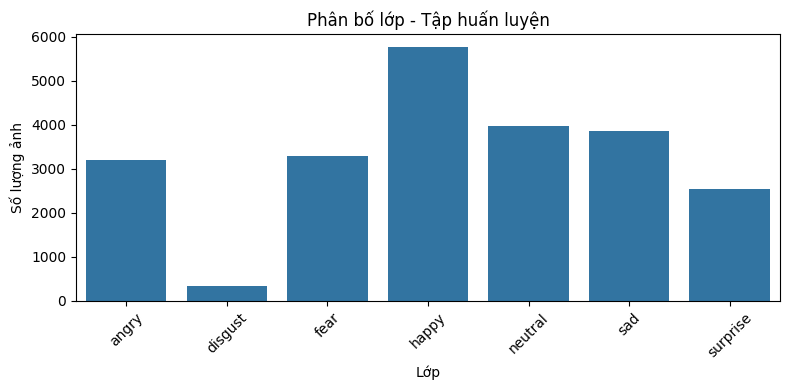

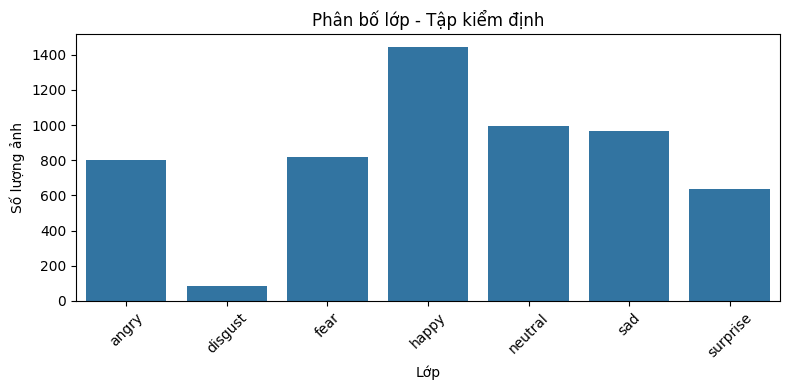

In [ ]:
#demo Chia tầng tập huấn luyện thành huấn luyện và kiểm định
import collections

def plot_class_distribution(dataset, title):
    targets = [dataset.dataset.targets[i] for i in dataset.indices]
    counter = collections.Counter(targets)
    labels = [class_names[i] for i in sorted(counter.keys())]
    counts = [counter[i] for i in sorted(counter.keys())]
    plt.figure(figsize=(8, 4))
    sns.barplot(x=labels, y=counts)
    plt.title(title)
    plt.ylabel("Số lượng ảnh")
    plt.xlabel("Lớp")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_ds, "Phân bố lớp - Tập huấn luyện")
plot_class_distribution(val_ds, "Phân bố lớp - Tập kiểm định")


In [ ]:
# %%
import torch.nn as nn
from torchvision.models import resnet50

def create_resnet50(num_classes):
    model = resnet50(pretrained=True)
    # Đóng băng các lớp trước đó (tùy chọn)
    # for param in model.parameters():
    #     param.requires_grad = False

    # Thay thế lớp cuối cùng (fully connected layer) cho số lớp đầu ra của bạn
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

model = create_resnet50(len(class_names))
print("✅ Đã tạo mô hình ResNet50")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 216MB/s]


✅ Đã tạo mô hình ResNet50


In [ ]:
# %%
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4, patience=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience)

    train_accs, val_accs = [], []
    val_losses, train_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = correct = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            _, pred = torch.max(out, 1)#
            correct += (pred == y).sum().item()# đếm số lượng dự đoán đúng
            running_loss += loss.item() * x.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / len(train_loader.dataset)#Accuracy = Số đúng / Tổng số.
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval(); val_correct = val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                _, pred = torch.max(out, 1)
                val_correct += (pred == y).sum().item()# đếm số lượng dự đoán đúng
                val_loss += loss.item() * x.size(0)

        val_acc = val_correct / len(val_loader.dataset)#Accuracy = Số đúng / Tổng số.
        val_losses.append(val_loss / len(val_loader.dataset))
        val_accs.append(val_acc)

        scheduler.step(val_loss)
        print(f"📍 Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f} | Train Loss: {train_loss:.4f} | Val Loss: {val_losses[-1]:.4f}")

    return model, train_accs, val_accs, train_losses, val_losses
# %%

In [ ]:
# Huấn luyện mô hình trong 10 epoch (hoặc số epoch bạn muốn)
model, train_acc, val_acc, train_loss, val_loss = train_model(model, train_loader, val_loader, num_epochs=10)

# Lưu lại mô hình sau khi huấn luyện
torch.save(model.state_dict(), "/content/resnet50_ep10_imagenet_norm.pth")
print("✅ Đã lưu mô hình ResNet50 sau 10 epoch với chuẩn hóa ImageNet")

📍 Epoch 1/10 | Train Acc: 0.55 | Val Acc: 0.59 | Train Loss: 1.1809 | Val Loss: 1.1157
📍 Epoch 2/10 | Train Acc: 0.63 | Val Acc: 0.64 | Train Loss: 0.9803 | Val Loss: 0.9637
📍 Epoch 3/10 | Train Acc: 0.66 | Val Acc: 0.64 | Train Loss: 0.8979 | Val Loss: 0.9718
📍 Epoch 4/10 | Train Acc: 0.69 | Val Acc: 0.67 | Train Loss: 0.8419 | Val Loss: 0.8993
📍 Epoch 5/10 | Train Acc: 0.70 | Val Acc: 0.67 | Train Loss: 0.7933 | Val Loss: 0.9030
📍 Epoch 6/10 | Train Acc: 0.72 | Val Acc: 0.66 | Train Loss: 0.7482 | Val Loss: 0.9759
📍 Epoch 7/10 | Train Acc: 0.74 | Val Acc: 0.66 | Train Loss: 0.7057 | Val Loss: 0.9721
📍 Epoch 8/10 | Train Acc: 0.80 | Val Acc: 0.70 | Train Loss: 0.5595 | Val Loss: 0.8883
📍 Epoch 9/10 | Train Acc: 0.82 | Val Acc: 0.70 | Train Loss: 0.4996 | Val Loss: 0.9144
📍 Epoch 10/10 | Train Acc: 0.83 | Val Acc: 0.70 | Train Loss: 0.4676 | Val Loss: 0.9387
✅ Đã lưu mô hình ResNet50 sau 10 epoch với chuẩn hóa ImageNet


<ipython-input-11-1454799483>:15: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-11-1454799483>:15: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


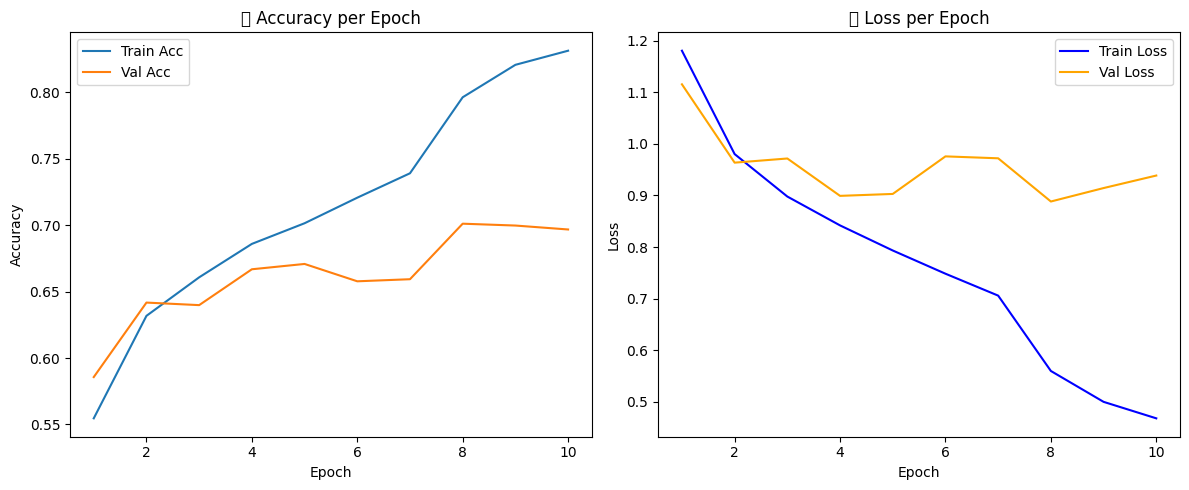

In [ ]:
# %%
epochs = range(1, len(train_acc)+1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_acc, label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.title("🎯 Accuracy per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_loss, label="Train Loss", color='blue')
plt.plot(epochs, val_loss, label="Val Loss", color='orange')
plt.title("📉 Loss per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.tight_layout()
plt.show()
# %%

📋 Classification Report
              precision    recall  f1-score   support

       angry       0.59      0.66      0.62       958
     disgust       0.74      0.65      0.69       111
        fear       0.54      0.52      0.53      1024
       happy       0.89      0.88      0.89      1774
     neutral       0.64      0.65      0.65      1233
         sad       0.57      0.56      0.57      1247
    surprise       0.82      0.77      0.80       831

    accuracy                           0.69      7178
   macro avg       0.69      0.67      0.68      7178
weighted avg       0.69      0.69      0.69      7178



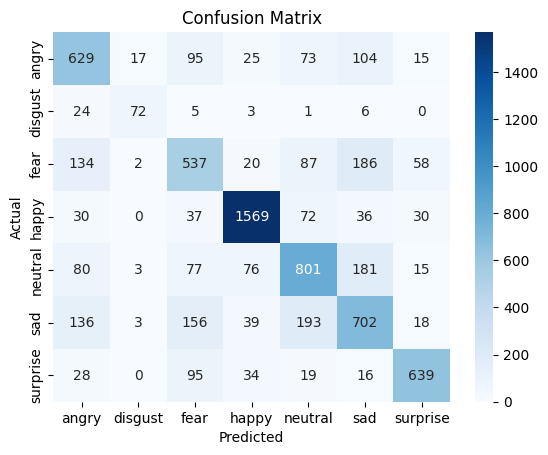

In [ ]:
# %%
def evaluate_model(model, test_loader, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device); model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            out = model(x)
            _, pred = torch.max(out, 1)
            y_true += y.tolist()
            y_pred += pred.cpu().tolist()

    print("📋 Classification Report")
    print(classification_report(y_true, y_pred, target_names=class_names))#tự động tính():
    #Precision: phần trăm đúng trong các dự đoán là lớp đó.
    #Recall: phần trăm đúng trong các mẫu thực sự thuộc lớp đó.
    #F1-score: trung bình điều hòa của Precision và Recall.
    #Support: số mẫu thực tế của từng lớp.

    cm = confusion_matrix(y_true, y_pred)#ma tran nhần lẫn tạo N*N
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
    plt.show()
evaluate_model(model, test_loader, class_names)

In [ ]:
# %%
# Hiển thị một số ảnh test cùng với dự đoán
def show_predictions_per_class(model, test_loader, class_names, max_per_class=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # Dictionary để lưu ảnh theo từng cảm xúc thật
    from collections import defaultdict
    images_to_show = defaultdict(list)

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            out = model(x)
            _, preds = torch.max(out, 1)

            for img_tensor, true_idx, pred_idx in zip(x.cpu(), y, preds.cpu()):
                if len(images_to_show[true_idx.item()]) < max_per_class:
                    images_to_show[true_idx.item()].append((img_tensor.cpu(), pred_idx.item()))

    # Hiển thị ảnh
    for emotion_idx in sorted(images_to_show.keys()):
        imgs = images_to_show[emotion_idx]
        if imgs:
            plt.figure(figsize=(12, 2))
            for i, (img_tensor, pred_idx) in enumerate(imgs):
                img = img_tensor.permute(1, 2, 0).numpy()
                img = (img - img.min()) / (img.max() - img.min())  # normalize về [0, 1]

                plt.subplot(1, len(imgs), i + 1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Pred: {class_names[pred_idx]}")
            plt.suptitle(f"True Emotion: {class_names[emotion_idx]}", y=1.05)
            plt.show()

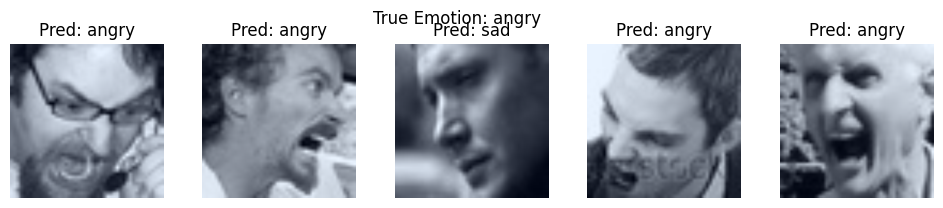

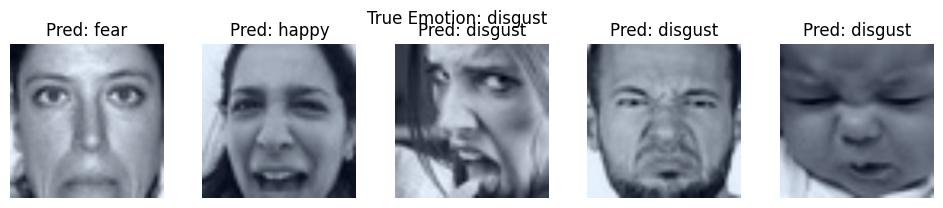

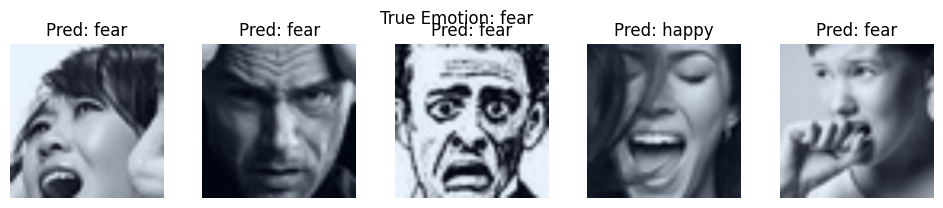

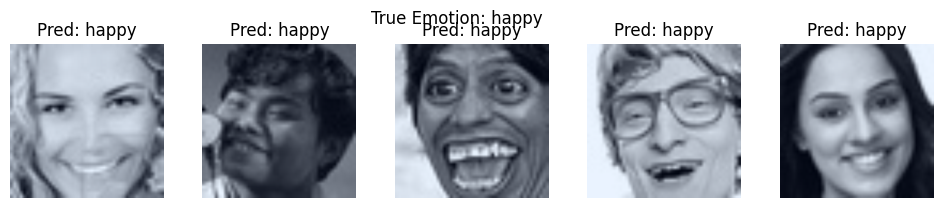

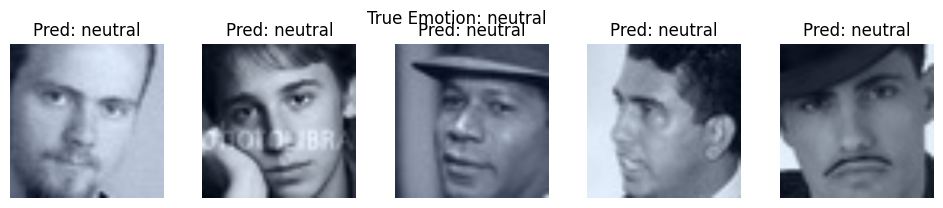

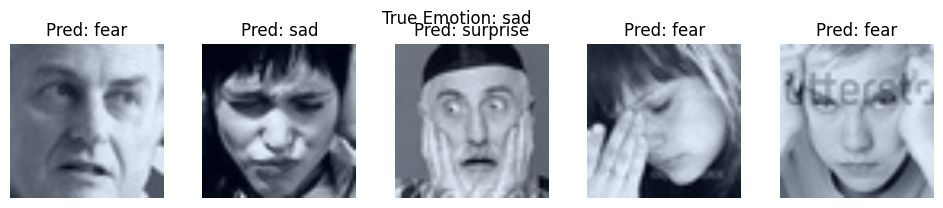

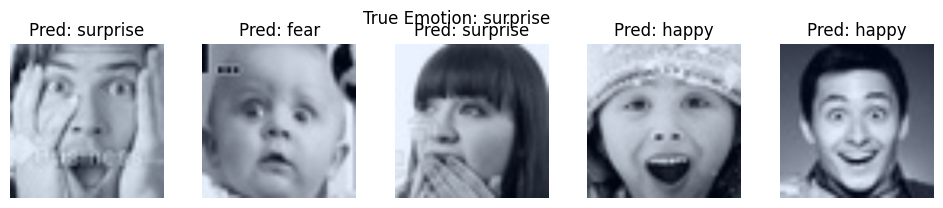

In [ ]:
show_predictions_per_class(model, test_loader, class_names)